## Project Overview

Millions of stray animals suffer on the streets or are euthanized in shelters every day around the world. If homes can be found for them, many precious lives can be saved — and more happy families created.

In this Project i will uncover the Secrets behind pet adoption.

### Project Goals

* Extract insights about what makes pets more likely adopted.
* Build a model that will predict adoption speed for pets 
* Perform some data cleaning, try out multiple ML models.


In [1]:
import pandas as pd   
import numpy as np
import seaborn as sns
import pandas.util.testing as tm
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score,make_scorer
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  KFold, cross_validate
from sklearn.preprocessing import StandardScaler
SEED = 42
sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/var/folders/sf/jsnvw4tn5bd5khnq5nncxv940000gn/T/ipykernel_16247/4208270524.py:4: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
breeds = pd.read_csv('data/breed_labels.csv')
color = pd.read_csv('data/color_labels.csv')
state = pd.read_csv('data/state_labels.csv')

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test/test.csv')
sub = pd.read_csv('data/test/sample_submission.csv')

# Exploratory Data Analysis

In [3]:
breeds.head()

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita


In [4]:
breeds.nunique()

BreedID      307
Type           2
BreedName    307
dtype: int64

There are 307 unique breed names in the dataset. They are classified into two types. 1 means dog, cat is 2.

In [5]:
print(color)
print(f"Number of unique colors of the animals are: ",color["ColorName"].nunique())

   ColorID ColorName
0        1     Black
1        2     Brown
2        3    Golden
3        4    Yellow
4        5     Cream
5        6      Gray
6        7     White
Number of unique colors of the animals are:  7


This color dataset contains the color of the animals. There are 7 unique colors in all.

In [6]:
state.head()

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan


In [7]:
print(f"States represented in the dataset are:",state["StateName"].nunique())

States represented in the dataset are: 15


In [8]:
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [9]:
# Missing values
total = train.isnull().sum().sort_values(ascending=False)
percent = ((train.isnull().sum()/train.isnull().count()) * 100).sort_values(ascending=False)
missing_values = pd.concat([total,percent], axis=1, keys = ["total","percent"])
print("Sorted missing values in descending order:")
missing_values.head(20)

Sorted missing values in descending order:


,total,percent
Name,1257,8.383912
Description,12,0.080037
Type,0,0.000000
PhotoAmt,0,0.000000
PetID,0,0.000000
VideoAmt,0,0.000000
RescuerID,0,0.000000
State,0,0.000000
Fee,0,0.000000
Quantity,0,0.000000


The dataset is mostly numeric. Names has about 8.38% of missing entries, since they are strayed animals and they can't say their names. It is quite understandable. I might take out th ones with missing description since the dataset is large enough. I am planning to do some sentiment analysis to see how the description helps with adoption speed.

### Which pet types are the most strayed?

In [10]:
df_train = train.copy()
def rename_values(df):
    df["Type"] = df["Type"].replace({1: "Dog", 2: "Cat"})
    df["Health"] = df["Health"].replace({1: "Healthy", 2: "Minor injury",
                            3:"Serious injury", 0:"Not specified"})
    df["Vaccinated"] = df["Vaccinated"].replace({1: "Yes", 2: "No",
                            3:"Not sure"})
    df["Gender"] = df["Gender"].replace({1: "Male", 2: "Female",
                            3:"Mixed"})
    df["Color1"] = df["Color1"].replace({1: "Black", 2: "Brown",
                            3:"Golden", 4:"Yellow", 5:"Cream", 6: "Gray", 7:"White"})
    df["Color2"] = df["Color2"].replace({1: "Black", 2: "Brown",
                            3:"Golden", 4:"Yellow", 5:"Cream", 6: "Gray", 7:"White"})
    df["MaturitySize"] = df["MaturitySize"].replace({1: "Small", 2: "Medium",
                            3:"Large", 4:"X-Large", 0:"Not specified"}) 
    df["FurLength"] = df["FurLength"].replace({1: "Short", 2: "Medium",
                            3:"Long",0:"Not specified"}) 
    df["Dewormed"] = df["Dewormed"].replace({1: "Yes", 2: "No",
                            3:"Not sure"})
    df["Sterilized"] = df["Sterilized"].replace({1: "Yes", 2: "No",
                            3:"Not sure"})

rename_values(df_train)
rename_values(test)
df_train["AdoptionSpeed"] = df_train["AdoptionSpeed"].replace({0: "Same Day", 1: "1-7 days",
                        2:"8 - 30 days", 3: "31-90 days",4:"> 100 days - None"})


In [11]:
def plot(label):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x="AdoptionSpeed", hue=label, data=df_train, order = df_train['AdoptionSpeed'].value_counts().index)
    for p in ax.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        ax.annotate('{:.2g}%'.format(100.*y/len(df_train)), (x.mean(), y), ha='center', va='bottom')

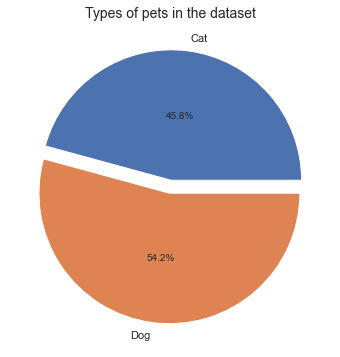

In [12]:
pet_type = df_train.groupby("Type").count()
pie, ax = plt.subplots(figsize=[10,6])
labels = pet_type["Breed1"].keys()
plt.pie(x=pet_type["Breed1"], autopct="%.1f%%", explode=[0.05]*2, labels=labels, pctdistance=0.5)
plt.title("Types of pets in the dataset", fontsize=14);

### Which pets have the fastest adoption speed?

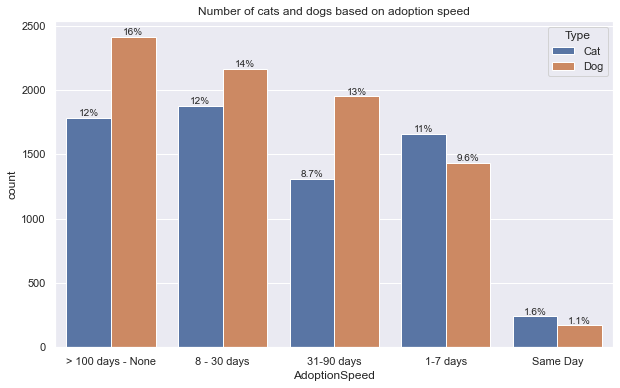

In [13]:
plot("Type")
plt.title('Number of cats and dogs based on adoption speed');


Cats are adopted faster than dogs for the first seven days at least compared to dogs.

### Is adoption speed based on health of the animal?

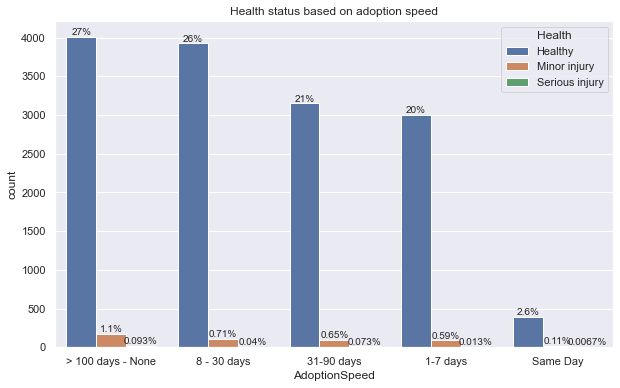

In [14]:
plot("Health")
plt.title('Health status based on adoption speed');


In [15]:
df_train["Health"].value_counts()

Healthy           14478
Minor injury        481
Serious injury       34
Name: Health, dtype: int64

Adoption speed doesn't look like it is tied to the health of the animal. If we compare the population of injured animal to their adoption speed.

### Is adoption speed based on vaccination of the animal?

Text(0.5, 1.0, 'Vaccination based on adoption speed')

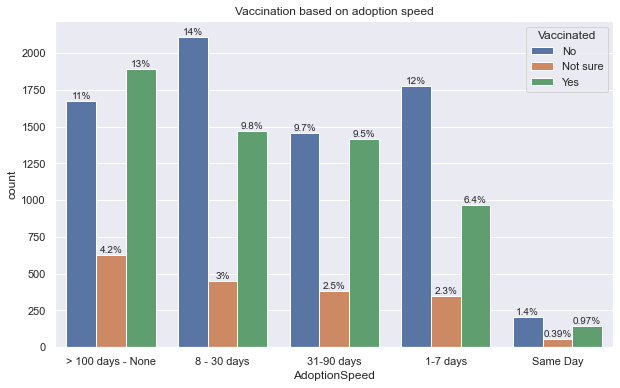

In [16]:
plot("Vaccinated")
plt.title('Vaccination based on adoption speed')

Vaccination does not determine how fast an animal is adopted. The vaccinated animal has like the highest percentage among the animals with no adoption 

### Do people prefer to adopt dewormed pets?

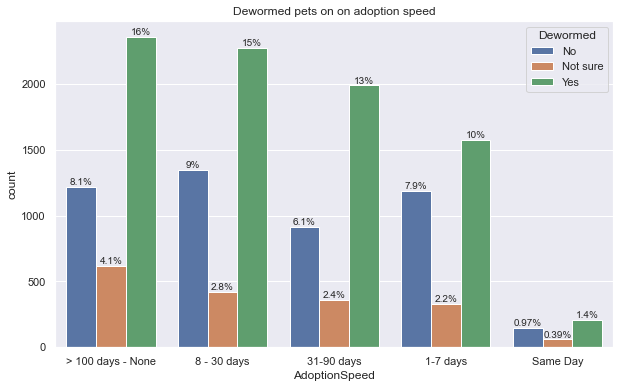

In [17]:
plot("Dewormed")
plt.title('Dewormed pets on on adoption speed');

### Are male animals adopted faster than female?

Text(0.5, 1.0, 'Gender based on adoption speed')

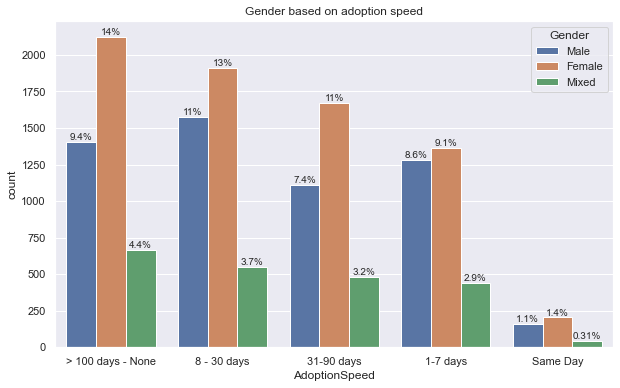

In [18]:
plot("Gender")
plt.title('Gender based on adoption speed')


In [19]:
df_train["Gender"].value_counts()

Female    7277
Male      5536
Mixed     2180
Name: Gender, dtype: int64

The graph clearly shows female animals are adopted faster than male and mixed gender. Though a drill dwon to the population of female animals to other genders in the dataset might shed some light. This is because, a large percentage of female animals are still left behind after hundred days.

In [20]:
df_train['Name'] = df_train['Name'].fillna('Unnamed')

In [21]:
#Create a new column called pure breed
df_train['pure_breed']= df_train['Breed2'].apply(lambda x: True if (x == 0) else False)
test['pure_breed']= test['Breed2'].apply(lambda x: True if (x == 0) else False)
# Create a new column for mixed color
df_train['mixed_color']= df_train['Color2'].apply(lambda x: False if (x == 0) else True)
test['mixed_color']= test['Color2'].apply(lambda x: False if (x == 0) else True)

### Are purebreeds adopted faster than mixed breeds?

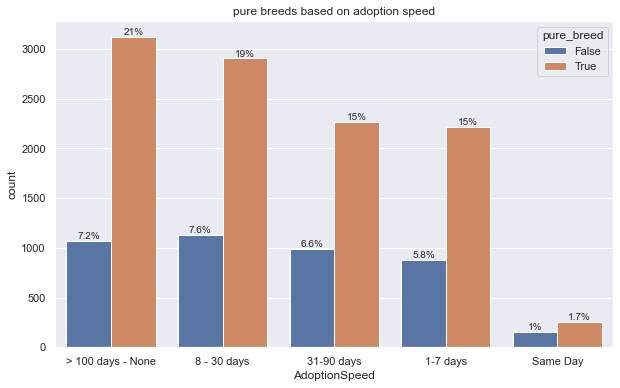

In [22]:
plot("pure_breed")
plt.title('pure breeds based on adoption speed');

Not really, if we compare the population of pure breeds to that of mixed breeds.

### is adoption speed based on color?

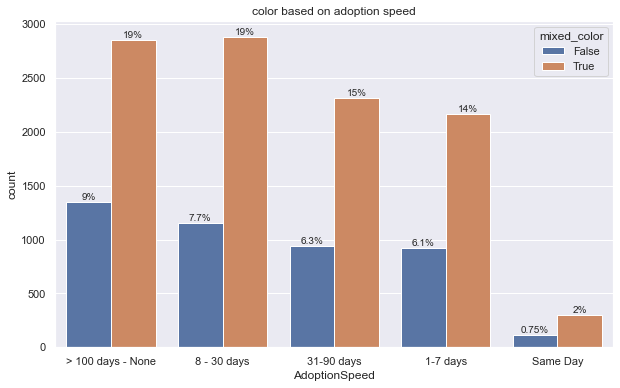

In [23]:
plot("mixed_color")
plt.title('color based on adoption speed');


In [24]:
df_train["mixed_color"].value_counts()

True     10522
False     4471
Name: mixed_color, dtype: int64

If compared to the population of the mixed color to a single color, color can not really be said to have any significant effect on adoption speed.

### Does maturity size affect adoption speed?

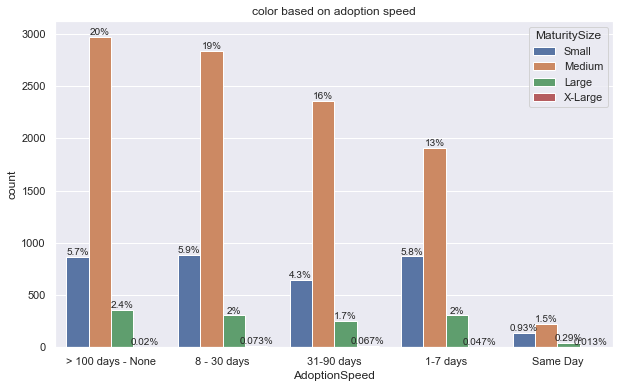

In [25]:
plot("MaturitySize")
plt.title('color based on adoption speed');

In [26]:
df_train["MaturitySize"].value_counts()

Medium     10305
Small       3395
Large       1260
X-Large       33
Name: MaturitySize, dtype: int64

Medium sized pets looks adopted faster but it might just be that the majority of the pets in the adoption centers are medium sized. From the value counts, it shows that the medium sized pets are more.

#### Correlation heatmap

Text(0.5, 1.0, 'AdoptionSpeed')

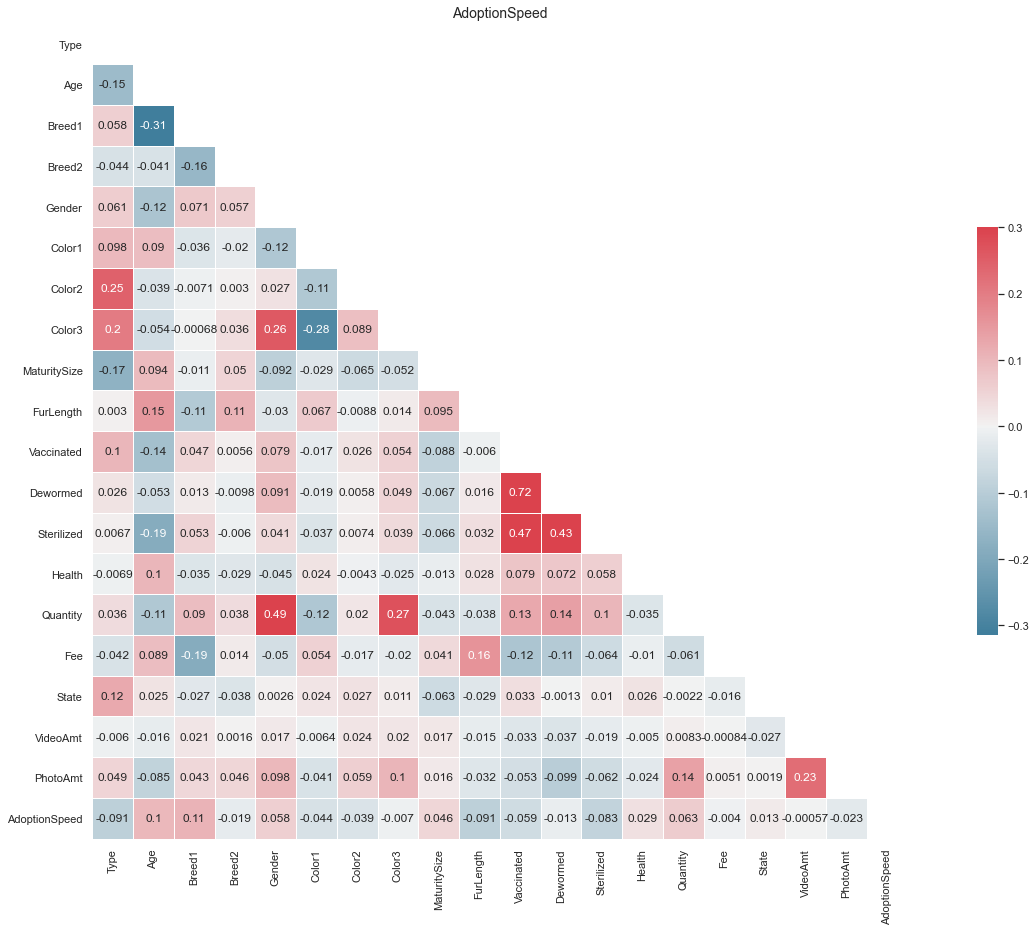

In [27]:
sns.set_theme(style="white")
df_adopt = train.copy()
df_adopt['AdoptionSpeed'].replace(to_replace=[ 0, 1, 2 ,3 ],value=0,inplace=True)
df_adopt['AdoptionSpeed'].replace(to_replace=[ 4 ],value=1,inplace=True)

f, ax = plt.subplots(1,1,figsize=(25,15))

corr = train.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 10, as_cmap=True)

ax = sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
            square=True, linewidths=.5,vmax=0.3, cbar_kws={"shrink": .5}, annot=True)
ax.set_title("AdoptionSpeed",fontsize=14)

Most of the variables are not correlated to adoption speed. Variables like `Age` and `Breed1` are quite correlated to adoption speed.

## Feature Engineering

In [28]:
train_df = df_train.copy()
target = train['AdoptionSpeed']
train_df.drop(['Name','Breed1','Breed2', 'State','RescuerID','Description','Color2','Color3','PetID','AdoptionSpeed'], axis=1, inplace=True)
test.drop(['Name','Breed1','Breed2', 'State','RescuerID','Description','Color2','Color3','PetID'], axis=1, inplace=True)

In [29]:
# Clean the fee column
train_df.loc[train_df['Fee']>=1, 'Fee']='Paid'
train_df.loc[train_df['Fee']==0, 'Fee']='Free'
test.loc[test['Fee']>=1, 'Fee']='Paid'
test.loc[test['Fee']==0, 'Fee']='Free'

# Clean the Video column
train_df.loc[train_df['VideoAmt']>=1, 'VideoAmt']='Yes'
train_df.loc[train_df['VideoAmt']==0, 'VideoAmt']='No'
test.loc[test['VideoAmt']>=1, 'VideoAmt']='Yes'
test.loc[test['VideoAmt']==0, 'VideoAmt']='No'

In [30]:
# List of categorical features
cat_features = list(train_df.select_dtypes(include=['object', 'category']).columns)
print("Categorical features:")
print(cat_features)
# List of numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_features = list(train_df.select_dtypes(include=numeric_dtypes).columns)
print("Numerical features:")
print(num_features)

Categorical features:
['Type', 'Gender', 'Color1', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Fee', 'VideoAmt']
Numerical features:
['Age', 'Quantity', 'PhotoAmt']


#### Encode Categorial Features

In [31]:
encoded_features = list()
for df in [train_df,test]:
    for feature in cat_features:
        encoded_feat = preprocessing.OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)
        
train_df = pd.concat([train_df, *encoded_features[:len(cat_features)]], axis=1)
test = pd.concat([test, *encoded_features[len(cat_features):]], axis=1)

In [32]:
train_data = train_df.drop(cat_features, axis=1)
test = test.drop(cat_features, axis=1)

#### Scaling

In [33]:
scaler = StandardScaler()
for cols in num_features:
    scaler.fit(train_data[cols].values.reshape(-1,1))
    train_data[cols] = scaler.transform(train_data[cols].values.reshape(-1,1))
    test[cols] = scaler.transform(test[cols].values.reshape(-1,1))

## Modeling

In [34]:
kappa_scorer = make_scorer(cohen_kappa_score,weights = "quadratic")

In [35]:
model_name = []
model_result = []
run_time = []
df = []
scoring = {"kappa": kappa_scorer}


def construct_models():
    """Function to create different models"""
    models = dict()
    models['Random_Forest_Classifier'] = RandomForestClassifier()
    models['Decison_tree_Classifier'] = DecisionTreeClassifier()
    models['Gradient_Boost_Classifier'] = GradientBoostingClassifier()
    models['Support_Vector_Clssifier'] = SVC()
    return models

models = construct_models()

In [36]:
import time
for name, model in models.items():
    start = time.perf_counter()
    kfolds = KFold(n_splits=10, shuffle=True, random_state=SEED)
    cv_results = cross_validate(model,train_data,target,cv=kfolds,scoring=scoring,return_train_score=True)
    run_t = time.perf_counter() - start
    model_name.append(name)
    model_result.append(cv_results)
    run_time.append(run_t)
    #Create a dataframe for result
    result_df = pd.DataFrame(cv_results)
    result_df['Model'] = name
    df.append(result_df)
    final_result_df = pd.concat(df, ignore_index=True)
    

### Results and Evaluation

In [37]:
final_result_df.groupby(['Model']).agg({'fit_time':'mean', 'test_kappa':'mean', 'train_kappa':'mean'}).reset_index().sort_values(by="test_kappa", ascending = False)

,Model,fit_time,test_kappa,train_kappa
1,Gradient_Boost_Classifier,6.036190,0.287927,0.329187
3,Support_Vector_Clssifier,11.050778,0.266044,0.321172
2,Random_Forest_Classifier,1.118474,0.246304,0.939362
0,Decison_tree_Classifier,0.082880,0.177391,0.937886


The Random Forest and Decision tree model shows overfitting with the data. The gradient boost classifier model has a good response with the dataset.

In [38]:
gb = GradientBoostingClassifier()
gb_model = gb.fit(train_data,target)

In [39]:
X_test = test.copy()

sub = pd.read_csv("data/test/sample_submission.csv")
pred = gb_model.predict(X_test)
sub.AdoptionSpeed=pred
sub.to_csv("submission1.csv",index=False)